In [1]:
import pandas as pd
import numpy as np

civious_df = pd.read_csv('./data/Dataset.csv.txt', delimiter='\t')

#### **데이터 전처리**

1. puntuation 제거 (숫자로 비속어를 표현하는 경우도 있기때문에 숫자는 남겨둠)

In [2]:
# civious_df['content'] = civious_df['content'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]","", regex=True)
civious_df['content'] = civious_df['content'].str.replace("[:punct:]","", regex=True)

null 값의 label을 직접 입력해줌

하는 김에 label도 int로 바꿔줌

In [3]:
for i in civious_df[civious_df['lable'].isnull()].index :
    textNlabel = civious_df.loc[i, 'content'].split('\t')
    civious_df.loc[i, 'lable'] = int(textNlabel[1])

In [4]:
civious_df['lable'] = civious_df['lable'].apply(lambda x : int(x))

In [5]:
civious_df['lable'] = civious_df['lable'].replace([1,0],[0,1])

In [6]:
civious_df.head(5)

,content,lable
0,이종석 한효주 나오는 드라마 이후로 드라마 안봤다. 2년전인가?? 좀 신선했었지. ...,1
1,씨바알..노무노무 술프노... 오늘 저녁은 꽂등심이다ㅠㅜ,1
2,짱깨 꺼라ㅡ패쓰,1
3,그들의 사생활 ~ 고인이된 설리를 위해서라도 모두 조용하길 지금 누굴 탓한다고 무슨...,0
4,아무리 법이 뭣같아도 무슨 자격으로 개인의 신상정보를 불특정 다수에게 공개하는지 도...,0


2. 중복 제거

In [7]:
civious_df.nunique()

content    9987
lable         2
dtype: int64

In [8]:
civious_df.drop_duplicates(subset=['content'], inplace=True, ignore_index=True)

In [9]:
civious_df.shape

(9987, 2)

3. puntuation 제거 후 빈 문자열이 된 데이터가 있는지 확인

In [10]:
civious_df['content'].replace('', np.nan, inplace=True)

In [11]:
civious_df.shape

(9987, 2)

In [12]:
print(civious_df.isnull().sum())

content    0
lable      0
dtype: int64


content column에 빈 문자열은 없음!

#### **토큰화**

In [13]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [14]:
import jpype #이거 안쓰면 에러남!!!!
from konlpy.tag import Okt

okt = Okt()
token_list = []

In [15]:
toknized_df = pd.DataFrame(columns=['text', 'label'])

In [16]:
for i in civious_df.index :
    sentence = civious_df.loc[i, 'content']
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    toknized_df.loc[i, 'text'] = temp_X

In [17]:
toknized_df['label'] = civious_df['lable']

In [18]:
toknized_df.head(5)

,text,label
0,"[이종석, 한효주, 나오다, 드라마, 이후, 로, 드라마, 안, 보다, ., 2년,...",1
1,"[씨, 바알, .., 노무, 노무, 술프노, ..., 오늘, 저녁, 꽂다, 등심, ...",1
2,"[짱깨, 끄다, ㅡ, 패쓰]",1
3,"[그, 사생활, ~, 고인, 되다, 설리, 위, 모두, 조용하다, 지금, 누굴, 탓...",0
4,"[아무리, 법, 뭣같아, 무슨, 자격, 개인, 신상, 정보, 불, 특정, 다수, 에...",0


#### **인코딩**

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(toknized_df['text'])

In [20]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if (value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 16173
등장 빈도가 2번 이하인 희귀 단어의 수: 10335
단어 집합에서 희귀 단어의 비율: 63.90280096457058
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.93964224694027


3회 미만으로 등장하는 단어가 8.9퍼센트를 차지한다.

In [21]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 5839


In [22]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(toknized_df['text'])
toknized_df['encoding'] = tokenizer.texts_to_sequences(toknized_df['text'])

In [23]:
toknized_df.head(5)

,text,label,encoding
0,"[이종석, 한효주, 나오다, 드라마, 이후, 로, 드라마, 안, 보다, ., 2년,...",1,"[2491, 1884, 34, 131, 926, 14, 131, 15, 3, 1, ..."
1,"[씨, 바알, .., 노무, 노무, 술프노, ..., 오늘, 저녁, 꽂다, 등심, ...",1,"[92, 5, 1438, 1438, 7, 305, 3185, 2223, 17, 2492]"
2,"[짱깨, 끄다, ㅡ, 패쓰]",1,"[449, 158, 405]"
3,"[그, 사생활, ~, 고인, 되다, 설리, 위, 모두, 조용하다, 지금, 누굴, 탓...",0,"[31, 1620, 30, 678, 10, 262, 231, 649, 726, 14..."
4,"[아무리, 법, 뭣같아, 무슨, 자격, 개인, 신상, 정보, 불, 특정, 다수, 에...",0,"[532, 540, 124, 1886, 571, 1524, 1220, 988, 37..."


문장을 구성하는 모든 단어가 희귀 단어여서 빈 encoding sequence를 생성하는 경우를 제거

In [24]:
drop_index = [index for index, sentence in enumerate(toknized_df['encoding']) if len(sentence) < 1]

In [25]:
len(drop_index)

12

In [26]:
toknized_df.drop(index=drop_index, axis=0, inplace=True)
# toknized_df = np.delete(toknized_df, drop_index, axis=0)
toknized_df.reset_index(inplace=True, drop=True)

In [27]:
toknized_df

,text,label,encoding
0,"[이종석, 한효주, 나오다, 드라마, 이후, 로, 드라마, 안, 보다, ., 2년,...",1,"[2491, 1884, 34, 131, 926, 14, 131, 15, 3, 1, ..."
1,"[씨, 바알, .., 노무, 노무, 술프노, ..., 오늘, 저녁, 꽂다, 등심, ...",1,"[92, 5, 1438, 1438, 7, 305, 3185, 2223, 17, 2492]"
2,"[짱깨, 끄다, ㅡ, 패쓰]",1,"[449, 158, 405]"
3,"[그, 사생활, ~, 고인, 되다, 설리, 위, 모두, 조용하다, 지금, 누굴, 탓...",0,"[31, 1620, 30, 678, 10, 262, 231, 649, 726, 14..."
4,"[아무리, 법, 뭣같아, 무슨, 자격, 개인, 신상, 정보, 불, 특정, 다수, 에...",0,"[532, 540, 124, 1886, 571, 1524, 1220, 988, 37..."
...,...,...,...
9970,"[거, 보다, 더하다, 막장, 드라마, 넋, 놓다, 보다, 무슨, ?]",0,"[46, 3, 1294, 1689, 131, 314, 3, 124, 2]"
9971,"[머, ..., 제네시스, .., 올라프, 에디, 션, ?]",0,"[379, 7, 2431, 5, 3044, 2]"
9972,"[항상, 여자, 로, ㅡ, ㅡ, 저, 지랄, 들이다, 남자, 벗기다, 보다]",1,"[434, 32, 14, 405, 405, 37, 137, 111, 67, 3]"
9973,"[첫, 번째, 이유, ㄹㅇ, 맞다, 특히, 나, 뉴스, 나, 기사, 몇, 줄, 읽다...",1,"[1331, 3312, 338, 597, 75, 841, 25, 779, 25, 9..."


#### **패딩**
샘플 길이 맞춰주는 과정

시퀀스 최대 길이 : 246
시퀀스 평균 길이 : 13.09032581453634


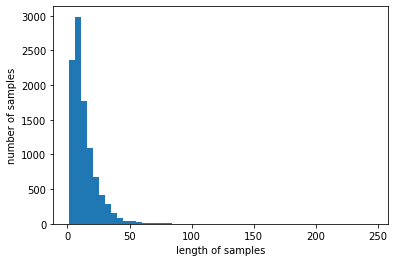

In [28]:
import matplotlib.pyplot as plt

print('시퀀스 최대 길이 :',max(len(l) for l in toknized_df['encoding']))
print('시퀀스 평균 길이 :',sum(map(len, toknized_df['encoding']))/len(toknized_df['encoding']))
plt.hist([len(s) for s in toknized_df['encoding']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

최적의 시퀀스 길이(대부분의 텍스트가 내용이 잘리지 않도록 할 수 있는 최적의 max_len의 값)는?

In [29]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [30]:
max_len = 40
below_threshold_len(max_len, toknized_df['encoding'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 97.50375939849624


전체 데이터 중 약 97%의 샘플이 40 이하의 길이를 가짐. 모든 시퀀스 길이를 40으로 맞추기로 결정.

In [31]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

encoded_text = pad_sequences(toknized_df['encoding'], maxlen = max_len)

In [32]:
encoded_df = pd.DataFrame(data=encoded_text)

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(encoded_df, toknized_df['label'], random_state=42)

#### **Machine learning**

1. Logistic regression

로지스틱 회귀는 실행할 때 regularation을 사용하기 때문에 그 전에 반드시 우리가 가진 데이터를 스케일링하는 작업이 필요하다.

In [34]:
from sklearn.preprocessing import StandardScaler
stand_scaler = StandardScaler()
X_train_lr = stand_scaler.fit_transform(X_train)
X_valid_lr = stand_scaler.transform(X_valid)

In [35]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()
lr_model.fit(X_train_lr, y_train)
print(lr_model.score(X_train_lr, y_train))

0.5399010827429488


In [36]:
print(lr_model.score(X_valid_lr, y_valid))

0.5352846832397755


In [37]:
def preprocess_text(new_sentence):
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    return pad_new

In [38]:
def lr_predict(new_sentence):
    processed_text = preprocess_text(new_sentence)
    processed_text = stand_scaler.transform(processed_text)
    score = float(lr_model.predict(processed_text)) # 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 악의적인 글입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 악의적인 글이 아닙니다.\n".format((1 - score) * 100))

In [39]:
lr_predict('이 영화 핵노잼 ㅠㅠ')

100.00% 확률로 악의적인 글이 아닙니다.



In [40]:
lr_predict('개소리야 니가 빨갱이를 옹호하고 드루킹을 ㅇㅇ짓이라고 말못해서 삐진거야')

100.00% 확률로 악의적인 글입니다.



2. Decision Tree Classifier

In [41]:
# from sklearn.model_selection import cross_val_score
# from sklearn.tree import DecisionTreeClassifier
# clf = DecisionTreeClassifier(random_state=0)
# cross_val_score(clf, iris.data, iris.target, cv=10)

In [42]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=0)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [43]:
print(lr_model.score(X_train, y_train))

0.5133003609143163


In [44]:
print(lr_model.score(X_valid, y_valid))

0.5164394546912591


3. Random Forest Model

In [45]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [46]:
print(rf_model.score(X_train, y_train))

1.0


In [47]:
print(rf_model.score(X_valid, y_valid))

0.5717722534081796


아마.. 과적합?

나이브 베이즈 분류기

In [48]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()

In [49]:
print(nb_model.score(X_train, y_train))

0.537494987301163


In [50]:
print(nb_model.score(X_valid, y_valid))

0.5437048917401764


### **Deep learning**

1. RNN (바닐라 RNN)

In [51]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

In [52]:
rnn_model = Sequential()
rnn_model.add(Embedding(vocab_size, 32)) # 임베딩 벡터의 차원은 32
rnn_model.add(SimpleRNN(32)) # RNN 셀의 hidden_size는 32
rnn_model.add(Dense(1, activation='sigmoid'))

rnn_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
rnn_history = rnn_model.fit(X_train, y_train, epochs=3, batch_size=64, validation_split=0.2)

Epoch 1/3
94/94 [==============================] - 4s 18ms/step - loss: 0.6318 - acc: 0.6317 - val_loss: 0.5362 - val_acc: 0.7047
Epoch 2/3
94/94 [==============================] - 2s 17ms/step - loss: 0.4110 - acc: 0.8172 - val_loss: 0.8577 - val_acc: 0.5912
Epoch 3/3
94/94 [==============================] - 1s 12ms/step - loss: 0.2856 - acc: 0.8892 - val_loss: 0.4082 - val_acc: 0.8056


In [53]:
print("\n validation set 정확도: %.4f" % (rnn_model.evaluate(X_valid, y_valid)[1]))

78/78 [==============================] - 0s 4ms/step - loss: 0.4203 - acc: 0.8071

 validation set 정확도: 0.8071


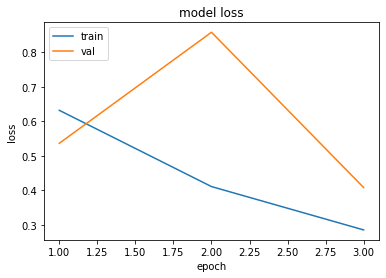

In [54]:
epochs = range(1, len(rnn_history.history['acc']) + 1)
plt.plot(epochs, rnn_history.history['loss'])
plt.plot(epochs, rnn_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

이번 실습 데이터는 데이터의 양이 적어 과적합이 빠르게 시작되므로, 검증 데이터에 대한 오차가 증가하기 시작하는 시점의 바로 직전인 에포크 3 정도가 적당

2. LSTM

In [55]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [56]:
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, 100))
lstm_model.add(LSTM(128))
lstm_model.add(Dense(1, activation='sigmoid'))

In [57]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc_lstm = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [58]:
lstm_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
lstm_history = lstm_model.fit(X_train, y_train, epochs=15, callbacks=[es, mc_lstm], batch_size=60, validation_split=0.2)

Epoch 1/15
100/100 [==============================] - 11s 76ms/step - loss: 0.5657 - acc: 0.7127 - val_loss: 0.4224 - val_acc: 0.7996

Epoch 00001: val_acc improved from -inf to 0.79960, saving model to best_model.h5
Epoch 2/15
100/100 [==============================] - 6s 59ms/step - loss: 0.3211 - acc: 0.8707 - val_loss: 0.3685 - val_acc: 0.8403

Epoch 00002: val_acc improved from 0.79960 to 0.84035, saving model to best_model.h5
Epoch 3/15
100/100 [==============================] - 6s 58ms/step - loss: 0.2339 - acc: 0.9086 - val_loss: 0.3631 - val_acc: 0.8457

Epoch 00003: val_acc improved from 0.84035 to 0.84569, saving model to best_model.h5
Epoch 4/15
100/100 [==============================] - 6s 64ms/step - loss: 0.1827 - acc: 0.9233 - val_loss: 0.3740 - val_acc: 0.8437

Epoch 00004: val_acc did not improve from 0.84569
Epoch 5/15
100/100 [==============================] - 6s 61ms/step - loss: 0.1528 - acc: 0.9395 - val_loss: 0.4343 - val_acc: 0.8524

Epoch 00005: val_acc improv

In [59]:
lstm_loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (lstm_loaded_model.evaluate(X_valid, y_valid)[1]))

78/78 [==============================] - 2s 16ms/step - loss: 0.4659 - acc: 0.8396

 테스트 정확도: 0.8396


In [60]:
# def preprocess_text(new_sentence):
#     new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
#     new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
#     encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
#     pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
#     return pad_new

In [61]:
def lstm_predict(new_sentence):
  processed_text = preprocess_text(new_sentence)
  score = float(lstm_loaded_model.predict(processed_text)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 악의적인 글입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 악의적인 글이 아닙니다.\n".format((1 - score) * 100))

In [62]:
lstm_predict('못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지')

97.10% 확률로 악의적인 글이 아닙니다.



In [63]:
lstm_predict("개소리야 니가 빨갱이를 옹호하고 드루킹을 ㅇㅇ짓이라고 말못해서 삐진거야 빨갱아")

99.99% 확률로 악의적인 글입니다.



In [64]:
lstm_predict('이 영화 핵노잼 ㅠㅠ')

99.95% 확률로 악의적인 글이 아닙니다.



In [65]:
lstm_predict('이딴게 영화냐 ㅉㅉ')

91.06% 확률로 악의적인 글입니다.



3. GRU

*Embedding : Embedding()은 두 개의 인자를 받는데, 첫번째 인자는 단어 집합의 크기이며 두번째 인자는 임베딩 후의 벡터 크기입니다. 여기서는 100을 선택했습니다. 즉, 입력 데이터에서 모든 단어는 100차원의 임베딩 벡터로 표현됩니다.

In [66]:
from tensorflow.keras.layers import Dense, GRU

gru_model = Sequential()
gru_model.add(Embedding(vocab_size, 100))
gru_model.add(GRU(128))
gru_model.add(Dense(1, activation='sigmoid'))

In [67]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc_gru = ModelCheckpoint('GRU_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [68]:
gru_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
gru_history = gru_model.fit(X_train, y_train, epochs=15, callbacks=[es, mc_gru], batch_size=60, validation_split=0.2)

NameError: name 'model' is not defined

In [ ]:
gru_loaded_model = load_model('GRU_model.h5')
print("\n 테스트 정확도: %.4f" % (gru_loaded_model.evaluate(X_valid, y_valid)[1]))